In [1]:
import cobra
import os
import numpy as np
from copy import copy
import re
import pandas as pd
import sys
import random
import cometspy as c

import itertools
os.environ["GUROBI_COMETS_HOME"] = "/opt/gurobi952/linux64"


# This notebook shows how one sets the multitoxins for the chosen 4 species.

The four models inhibit each other based upon constitutive inhibition tests done by Molly.

The parameters result in 50% less growth of the affected, when grown in coculture with the producer, in glucose minimal media. 

The way the "multitoxins" work is by chaining together multiple hill functions. This requires we state what the maximum growth rate could be in the absence of toxins, and then what the km and hill parameters are for each toxin.

These models were made with carveme, gap-filling on BIOLOG-known growth, then gapclosing (by turning off transport reactions) on BIOLOG no growth. They used the "grampos" biomass reaction.

In [2]:

unlimited = ["EX_ca2_e","EX_cl_e","EX_co2_e","EX_cobalt2_e","EX_cu2_e",
             "EX_fe2_e","EX_fe3_e","EX_h_e","EX_h2o_e","EX_k_e","EX_mg2_e",
             "EX_mn2_e","EX_mobd_e","EX_na1_e","EX_nh4_e","EX_ni2_e",
             "EX_o2_e","EX_pi_e","EX_sel_e","EX_slnt_e","EX_so4_e",
             "EX_tungs_e","EX_zn2_e"]


model_dir = "./models/"

model_shortnames = {"B" : "ST32113_grampos",
             "F" : "ST32123_grampos",
             "G" : "ST32124_grampos",
             "I" :"ST32133_grampos"}

model_ids = list(model_shortnames.values())
B = cobra.io.read_sbml_model(model_dir + model_shortnames["B"] + "_2022gapclosed.xml")
B.id = "B"
F = cobra.io.read_sbml_model(model_dir + model_shortnames["F"] + "_2022gapclosed.xml")
F.id = "F"
G = cobra.io.read_sbml_model(model_dir + model_shortnames["G"] + "_2022gapclosed.xml")
G.id = "G"
I = cobra.io.read_sbml_model(model_dir + model_shortnames["I"] + "_2022gapclosed.xml")
I.id = "I"

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


# The next part makes models produce toxin, as well as be able to "see" (i.e. have an exchange reaction for) toxins which influence them.

Here are the specific relationships:

1. Strain B makes "B_toxin", and is harmed by "F_toxin" and "G_toxin"
2. Strain F makes "F_toxin" and is harmed by "B_toxin" and "G_toxin"
3. Strain G makes "G_toxin" and is harmed by "B_toxin" and "F_toxin"
4. Strain I is harmed by "B_toxin"

Like all toxin-related COMETS stuff, there are two steps: 1) getting the metabolite production and visibility arranged in the cobra metabolic model, then 2) adding the actual signal/toxin relationship in cometspy. 

Here, since > 1 toxin can affect a species, we use cometspy's "multitoxin" approach.

In [3]:

### Make the cobra models which make toxin, export it, and see it
from cobra import Metabolite, Reaction

B_toxin_c = Metabolite("B_toxin_c", compartment = "C_c")
B_toxin_e = Metabolite("B_toxin_e", compartment = "C_e")
B_objective = B.reactions.Growth
# arbitrarily have one unit of toxin produced for 1 gram of cells
B_objective.add_metabolites({B_toxin_c: 1.})
B_toxin_tpp = Reaction("B_toxin_tpp", 
                       lower_bound = 0, upper_bound = 1000)
B_toxin_tpp.add_metabolites({B_toxin_c : -1,
                       B_toxin_e: 1})
B.add_reactions([B_toxin_tpp])
B.add_boundary(B_toxin_e, type = "exchange",
               lb = 0, ub = 1000)



F_toxin_c = Metabolite("F_toxin_c", compartment = "C_c")
F_toxin_e = Metabolite("F_toxin_e", compartment = "C_e")
F_objective = F.reactions.Growth
# arbitrarily have one unit of toxin produced for 1 gram of cells
F_objective.add_metabolites({F_toxin_c: 1.})
F_toxin_tpp = Reaction("F_toxin_tpp", 
                       lower_bound = 0, upper_bound = 1000)
F_toxin_tpp.add_metabolites({F_toxin_c : -1,
                       F_toxin_e: 1})
F.add_reactions([F_toxin_tpp])
F.add_boundary(F_toxin_e, type = "exchange",
               lb = 0, ub = 1000)


G_toxin_c = Metabolite("G_toxin_c", compartment = "C_c")
G_toxin_e = Metabolite("G_toxin_e", compartment = "C_e")
G_objective = G.reactions.Growth
# arbitrarily have one unit of toxin produced for 1 gram of cells
G_objective.add_metabolites({G_toxin_c: 1.})
G_toxin_tpp = Reaction("G_toxin_tpp", 
                       lower_bound = 0, upper_bound = 1000)
G_toxin_tpp.add_metabolites({G_toxin_c : -1,
                       G_toxin_e: 1})
G.add_reactions([G_toxin_tpp])
G.add_boundary(G_toxin_e, type = "exchange",
               lb = 0, ub = 1000)


# B needs to see F,G
# F needs to see B,G
#G needs to see B, F
#I needs to see B

B.add_boundary(F_toxin_e, type = "exchange",
               lb = 0, ub = 0)
B.add_boundary(G_toxin_e, type = "exchange",
               lb = 0, ub = 0)
F.add_boundary(B_toxin_e, type = "exchange",
               lb = 0, ub = 0)
F.add_boundary(G_toxin_e, type = "exchange",
               lb = 0, ub = 0)
G.add_boundary(B_toxin_e, type = "exchange",
               lb = 0, ub = 0)
G.add_boundary(F_toxin_e, type = "exchange",
               lb = 0, ub = 0)
I.add_boundary(B_toxin_e, type = "exchange",
               lb = 0, ub = 0)

Reaction identifier,EX_B_toxin_e
Name,exchange
Memory address,0x07f3ea1f86d30
Stoichiometry,B_toxin_e --> -->
GPR,
Lower bound,0
Upper bound,0


In [4]:
I.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
Metabolite,Reaction,Flux,C-Number,C-Flux


In [5]:

### Make the COMETS models with the constitive toxins

B_comets = c.model(B)
B_comets.id = "B"
F_comets = c.model(F)
F_comets.id = "F"
G_comets = c.model(G)
G_comets.id = "G"
I_comets = c.model(I)
I_comets.id = "I"

B_comets.open_exchanges()
F_comets.open_exchanges()
G_comets.open_exchanges()
I_comets.open_exchanges()

B_comets.initial_pop = [[0,0, 0.01]]
F_comets.initial_pop = [[0,0, 0.01]]
G_comets.initial_pop = [[0,0, 0.01]]
I_comets.initial_pop = [[0,0, 0.01]]


# First, we will just make the comets models without the toxin signals and run a well-mixed simulation. 

In [6]:
params = c.params()
params.set_param("timeStep", .1)
params.set_param("maxCycles", 200)
params.set_param("spaceWidth", 10) # cm
params.set_param("defaultKm", 0.000001)
params.set_param("maxSpaceBiomass", 1000)
params.set_param("writeMediaLog", True)
params.set_param("MediaLogRate", 1)
params.set_param("writeFluxLog", True)
params.set_param("FluxLogRate", 1)

In [7]:

unlimited = ["EX_ca2_e","EX_cl_e","EX_co2_e","EX_cobalt2_e","EX_cu2_e",
             "EX_fe2_e","EX_fe3_e","EX_h_e","EX_h2o_e","EX_k_e","EX_mg2_e",
             "EX_mn2_e","EX_mobd_e","EX_na1_e","EX_nh4_e","EX_ni2_e",
             "EX_o2_e","EX_pi_e","EX_sel_e","EX_slnt_e","EX_so4_e",
             "EX_tungs_e","EX_zn2_e"]
cobra_medium = {key: 10. for key in unlimited}
cobra_medium
cobra_medium["EX_glc__D_e"] = 10.


Running COMETS simulation ...
Done!


<AxesSubplot:xlabel='cycle'>

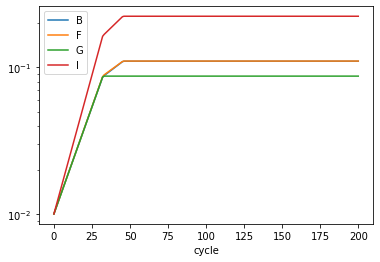

In [8]:
# baseline, just constitutive toxins
models = [B_comets, F_comets, G_comets, I_comets]


layout = c.layout(models)
for met in unlimited:
    met = met[3:]
    if met in layout.media.metabolite.values:
        layout.set_specific_metabolite(met, 1000.)
layout.set_specific_metabolite("glc__D_e", 5.)

sim = c.comets(layout, params)
sim.VERSION = "comets_multitoxin"
sim.set_classpath("bin", '/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_multitoxin.jar')
sim.run(delete_files = True)
baseline = sim.total_biomass
baseline.plot(x = "cycle", logy = True)

In [9]:
B_comets.reactions.loc[B_comets.reactions.REACTION_NAMES == "Growth",:]

,REACTION_NAMES,ID,LB,UB,EXCH,EXCH_IND,V_MAX,KM,HILL
2137,Growth,2138,0.0,1000.0,False,0,NaN,NaN,NaN


In [10]:
B_comets.reactions.loc[B_comets.reactions.REACTION_NAMES == "EX_F_toxin_e",:]

,REACTION_NAMES,ID,LB,UB,EXCH,EXCH_IND,V_MAX,KM,HILL
2152,EX_F_toxin_e,2153,-1000.0,1000.0,True,229,NaN,NaN,NaN


In [11]:
B_comets.reactions.loc[B_comets.reactions.REACTION_NAMES == "EX_G_toxin_e",:]

,REACTION_NAMES,ID,LB,UB,EXCH,EXCH_IND,V_MAX,KM,HILL
2153,EX_G_toxin_e,2154,-1000.0,1000.0,True,230,NaN,NaN,NaN


## Second, we will add the multitoxin signals and re-run in well-mixed env.

Note that we must specify a maximum growth rate.  Often I will do this by calculating the max growth rate. In the actual simulations, we may wish to set them all to the lowest any of the four models can achieve on that medium.

Multitoxins are added using the model.add_multitoxin() function. This takes six arguments:

1. The affected reaction (usually the biomass reaction)
2. The exchange indices of the toxins, in a list
3. Whether the upper or lower bound is affected (really, upper bound is all that makes sense)
4. The max flux through that reaction in the absence of toxins. If the biomass reaction is the affected reaction, this should be the maximum growth rate achievable in the medium.
5. A list of km values associated with the toxins
6. A list of hill coefficients associated with the toxins.

imagine two toxins concentrations, "a" and "b", which are the mmol amount / spaceWidth^3, and which have exchange indices 40 and 56.

Imagine a growth rate maximum in the absence of toxins of "vmax", and a biomass # 300.

Imagine they have kms k_a and k_b, and hill coefficients h_a and h_b. 

actual_bound = $vmax * \frac{k_a ^ {h_a}}{k_a^{h_a} + a^{h_a}}* \frac{k_b^ {h_b}}{k_b^{h_b} + b^{h_b}}$

Higher hill coefficients will cause more rapid changes as concentration approaches km. 


The above would be used with model.add_multitoxin(300, \[40, 56\], "ub", vmax, \[k_a, k_b\], \[h_a, h_b\])

In [12]:
B_comets = c.model(B)
B_comets.id = "B"
F_comets = c.model(F)
F_comets.id = "F"
G_comets = c.model(G)
G_comets.id = "G"
I_comets = c.model(I)
I_comets.id = "I"

B_comets.open_exchanges()
F_comets.open_exchanges()
G_comets.open_exchanges()
I_comets.open_exchanges()

B_comets.initial_pop = [[0,0, 0.01]]
F_comets.initial_pop = [[0,0, 0.01]]
G_comets.initial_pop = [[0,0, 0.01]]
I_comets.initial_pop = [[0,0, 0.01]]

B.medium = {k:10. for k,v in cobra_medium.items() if k in [e.id for e in B.exchanges]}
B_growth_rate_max = B.slim_optimize(0)
B_comets.add_multitoxin(2138, [229, 230], "ub", B_growth_rate_max, [2.e-5, 2.e-5], [5,5])
                        
                        
             #           [0.00010554809570312502,
              #           0.00010132179260253905], [5, 5])

# effects of G and B on F
F.medium = {k:10. for k,v in cobra_medium.items() if k in [e.id for e in F.exchanges]}
F_growth_rate_max = F.slim_optimize(0)
F_comets.add_multitoxin(2246, [265, 264], "ub", F_growth_rate_max, [2.e-5, 2.e-5], [5,5])
               #     [0.00010336053967475891,
               #      0.00010313453674316405], [5, 5])

#effect of B on G
G.medium = {k:10. for k,v in cobra_medium.items() if k in [e.id for e in G.exchanges]}
G_growth_rate_max = G.slim_optimize(0)
G_comets.add_multitoxin(2139, [234], "ub", G_growth_rate_max, [1.e-3], [5])
              #  [8.088378906250001e-05], [5])

# effect of B on I
I.medium = {k:10. for k,v in cobra_medium.items() if k in [e.id for e in I.exchanges]}
I_growth_rate_max = I.slim_optimize(0)
I_comets.add_multitoxin(2488, [275], "ub", I_growth_rate_max, [1], [5])
           # [8.13232421875e-05], [5])


/home/jeremy/miniconda3/envs/comets/lib/python3.8/site-packages/cometspy/model.py:185: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.multitoxins = self.multitoxins.append(new_row, ignore_index=True)
/home/jeremy/miniconda3/envs/comets/lib/python3.8/site-packages/cometspy/model.py:185: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.multitoxins = self.multitoxins.append(new_row, ignore_index=True)
/home/jeremy/miniconda3/envs/comets/lib/python3.8/site-packages/cometspy/model.py:185: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.multitoxins = self.multitoxins.append(new_row, ignore_index=True)
/home/jeremy/miniconda3/envs/comets/lib/python3.8/site-packages/cometspy/model.py:185: FutureWarning: The frame.append me

In [13]:
models = [B_comets, F_comets, G_comets, I_comets]


layout = c.layout(models)
for met in unlimited:
    met = met[3:]
    if met in layout.media.metabolite.values:
        layout.set_specific_metabolite(met, 1000.)
layout.set_specific_metabolite("glc__D_e", 5.)

sim = c.comets(layout, params)
sim.VERSION = "comets_multitoxin.jar"
sim.set_classpath("bin", '/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_multitoxin.jar')
print(sim.VERSION)
sim.run(delete_files = True)
withtoxins = sim.total_biomass


comets_multitoxin.jar

Running COMETS simulation ...
Done!


<AxesSubplot:xlabel='cycle'>

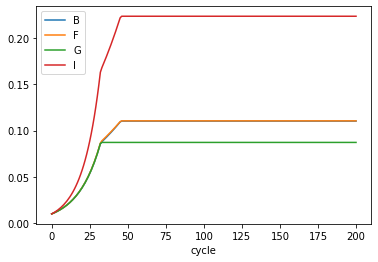

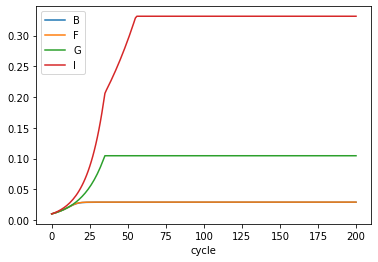

In [14]:
baseline.plot(x = "cycle")
withtoxins.plot(x = "cycle")

# the parameters above cause a pretty instantaneous effect that makes growth go from full to none once the toxin concentrations are near km. It is certainly worth playing with the parameters, possibly one model pair at a time, to develop the dynamics desired.

# Regardless, it is straightforward to place these models in a spatial environment just like we would any others:

In [15]:
def pick_unique_locations(width, height, n, edge_space = 0):
    locs = []
    while len(locs) < n:
        loc = (random.randrange(edge_space, width - edge_space),
               random.randrange(edge_space, height - edge_space))
        if loc not in locs:
            locs.append(loc)
    return(locs)

grid_size =[30, 30] # this was 100x100 in the actual sims!

locs = pick_unique_locations(grid_size[0], grid_size[1], 40, 3)
B_locs = locs[0:10]
F_locs = locs[10:20]
G_locs = locs[20:30]
I_locs = locs[30:40]


In [16]:
initial_biomass = 1.e-10
B_comets.initial_pop = [[loc[0], loc[1], initial_biomass] for loc in B_locs]
F_comets.initial_pop = [[loc[0], loc[1], initial_biomass] for loc in F_locs]
G_comets.initial_pop = [[loc[0], loc[1], initial_biomass] for loc in G_locs]
I_comets.initial_pop = [[loc[0], loc[1], initial_biomass] for loc in I_locs]

params.set_param("spaceWidth", 0.02) # cm, changing this will influence toxicity, need t play with
params.set_param("minSpaceBiomass", 1.e-15)

layout = c.layout([B_comets,F_comets,G_comets,I_comets])
layout.grid = grid_size
for met in unlimited:
    met = met[3:]
    if met in layout.media.metabolite.values:
        layout.set_specific_metabolite(met, 1000.)
layout.set_specific_metabolite("glc__D_e", 4.e-7)

sim = c.comets(layout, params)
sim.VERSION = "comets_multitoxin"
sim.set_classpath("bin", '/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_multitoxin.jar')
sim.run(delete_files = True)
baseline = sim.total_biomass
baseline.plot(x = "cycle", logy = True)



Running COMETS simulation ...


KeyboardInterrupt: 